In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import linregress

In [2]:
basePath = '../sims.TNG/TNG300-1/output/'
SnapNum = 99

In [3]:
# Minimum masses of the halos to select
threshold_mass = 10**14.5 

In [4]:
# Corresponding to their respective redshifts
required_snapshots = [17, 13, 11, 8] 
tot_snaps = len(required_snapshots)
# tot_snaps

In [5]:
redshifts = []
for i in range(tot_snaps):
    header = il.groupcat.loadHeader(basePath, required_snapshots[i])
    if i == 0:
        box_size = header['BoxSize']
    redshifts.append(round(header['Redshift']))

In [6]:
# Defining a function for unit conversion
def UnitConversion(array, SnapNum, unit):
    if SnapNum != None:
        header = il.groupcat.loadHeader(basePath, SnapNum)
        h = header['HubbleParam']
        a = header['Time']
        if unit == 'mass':
            array = array * 1e10 / h # In Msun unit
        if unit == 'length':
            array = array * a / (1e3 * h) # In Mpc unit
    return array

In [7]:
fields = ['Group_M_Crit200', 'GroupFirstSub']

In [8]:
halos = il.groupcat.loadHalos(basePath, SnapNum, fields=fields)

In [9]:
halos_mass = UnitConversion(halos['Group_M_Crit200'], SnapNum, 'mass')
halos_mass

array([1.5357900e+15, 1.3073401e+15, 1.0333144e+15, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [10]:
# Selecting the halos above a certain threshold mass
halo_IDs = np.nonzero(halos_mass >= threshold_mass)
halo_IDs[0], len(halo_IDs[0])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 30, 31, 32, 33, 34, 35, 36,
        39, 41, 43, 44, 48, 49, 50]),
 41)

In [11]:
# Extracting the central subhalos of the selected halos
sub_halos_ID = halos['GroupFirstSub'][halo_IDs]
n = len(sub_halos_ID)
# sub_halos_ID, n

In [12]:
fields = ['SnapNum', 'Group_M_Crit200', 'SubhaloMassInRadType', 'SubfindID']

In [13]:
trees = [{} for _ in range(n)]

In [14]:
# Loading the merger trees of different subhalos using the Sublink algorithm
for i in range(n):
    trees[i] = il.sublink.loadTree(basePath, SnapNum, sub_halos_ID[i], fields=fields, onlyMPB=True)

In [15]:
# Initialising the required arrays
halo_mass = [[] for _ in range(tot_snaps)]
subhalo_id = [[] for _ in range(tot_snaps)]
total_mass = [[] for _ in range(tot_snaps)]
stellar_mass = [[] for _ in range(tot_snaps)]
total_halo_mass = []
total_stellar_mass = []

In [16]:
# Extracting the masses for various snapshots
for i in range(tot_snaps):
    for tree in trees:
        halo_mass[i].extend(UnitConversion(tree['Group_M_Crit200'][tree['SnapNum'] == required_snapshots[i]], required_snapshots[i], 'mass'))
        temp = UnitConversion(tree['SubhaloMassInRadType'][tree['SnapNum'] == required_snapshots[i]], required_snapshots[i], 'mass')
        subhalo_id[i].extend(tree['SubfindID'][tree['SnapNum'] == required_snapshots[i]])
        # print(temp[0][5])
        stellar_mass[i].append(temp[0][4])
        # total_mass[i].extend(UnitConversion(tree['GroupMassType'][tree['SnapNum'] == required_snapshots[i]], required_snapshots[i], 'mass'))
    halo_mass[i] = np.array(halo_mass[i])  
    stellar_mass[i] = np.array(stellar_mass[i])
    subhalo_id[i] = np.array(subhalo_id[i])  
    total_halo_mass.extend(halo_mass[i])
    # total_bh_mass.extend(bh_mass[i])
    total_stellar_mass.extend(stellar_mass[i])

In [17]:
format(np.min(total_halo_mass), '.3g')

'9.9e+09'

In [18]:
# nonzero_bh = np.where(np.array(total_bh_mass) == 0.0, 1 + np.array(total_bh_mass), np.array(total_bh_mass))
# np.count_nonzero(np.array(nonzero_bh) >= 1)

In [19]:
# np.count_nonzero(total_stellar_mass), len(total_stellar_mass)

In [20]:
# nonzero_stellar = np.where(np.array(total_stellar_mass) == 0.0, 1 + np.array(total_stellar_mass), np.array(total_stellar_mass))
# np.count_nonzero(np.array(nonzero_bh) >= 1)

In [21]:
bh_mass = [[] for _ in range(tot_snaps)]
total_bh_mass = []
error = []

for i in range(tot_snaps):
    for j in range(n):
        bh_data = il.snapshot.loadSubhalo(basePath, required_snapshots[i], subhalo_id[i][j], partType=5, fields=['BH_Mass', 'Masses'])
        if bh_data['count'] > 0:
            bh_mass[i].append(UnitConversion(bh_data['BH_Mass'][0], required_snapshots[i], 'mass'))
        else:
            error.append((i, j))
    bh_mass[i] = np.array(bh_mass[i])
    total_bh_mass.extend(bh_mass[i])

In [22]:
x2 = [err[1] for err in error if err[0] == 2]
x3 = [err[1] for err in error if err[0] == 3]

In [23]:
x2

[11, 31, 39]

In [24]:
x3

[4, 6, 7, 9, 11, 12, 19, 23, 26, 27, 28, 31, 39]

In [25]:
mask = np.ones(len(halo_mass[2]), dtype=bool)
mask[x2] = False
filtered_halo_mass = halo_mass[2][mask]
halo_mass[2] = filtered_halo_mass
zeros = np.zeros((n - len(halo_mass[2])), dtype=halo_mass[2].dtype)
halo_mass_extended = np.concatenate((halo_mass[2], zeros))
bh_mass_extended = np.concatenate((bh_mass[2], zeros))
halo_mass[2] = halo_mass_extended
bh_mass[2] = bh_mass_extended

In [26]:
halo_mass[2]

array([9.0558077e+11, 4.4670907e+11, 4.1693702e+11, 4.2660256e+11,
       4.5659394e+10, 1.1977181e+12, 5.9387589e+10, 2.1734670e+11,
       4.9614143e+11, 1.0982252e+11, 9.0812495e+11, 1.2907874e+11,
       8.5228087e+11, 2.6495141e+11, 2.4050288e+11, 5.7486914e+11,
       2.4565131e+11, 1.3116668e+11, 3.1574829e+11, 1.4336485e+11,
       6.9105418e+11, 1.2481204e+11, 6.8012216e+10, 4.0862224e+11,
       8.5378086e+11, 1.7488842e+11, 1.0213849e+11, 9.3816152e+10,
       3.6876242e+11, 3.6055243e+11, 8.6519926e+11, 7.7163282e+10,
       3.0645604e+11, 2.4018035e+11, 1.1714931e+12, 2.3731567e+11,
       2.0149376e+11, 1.6118913e+11, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00], dtype=float32)

In [27]:
bh_mass[2]

array([ 5101024.58331753,  1598394.48453883,  1816756.34835249,
        1249775.25677103,  1181327.5501666 , 10796898.12108738,
        1192270.7021248 ,  1246647.04611919,  4376316.00437142,
        1195995.14603197,  7328472.5417997 ,  1223829.71178355,
        2098690.14640656,  1640841.65220393,  1273046.61343964,
        2213480.13917211,  1371884.38599578,  1260970.82237542,
        1301296.85613198,  1254416.87519942,  1586514.07237778,
        1238864.3278315 ,  1188182.46033692,  2619069.34170652,
       12964477.8590943 ,  1222542.07995777,  1218836.21799136,
        1194615.14155268,  1413843.05269794,  2468337.79392387,
        5627266.00499285,  1226576.18707429,  1273741.34172202,
        1384952.4312147 ,  8236631.49203897,  1294287.4902922 ,
        1334507.9399576 ,  1262485.08943248,        0.        ,
              0.        ,        0.        ])

In [28]:
mask = np.ones(len(halo_mass[3]), dtype=bool)
mask[x3] = False
filtered_halo_mass = halo_mass[3][mask]
halo_mass[3] = filtered_halo_mass
zeros = np.zeros((n - len(halo_mass[3])), dtype=halo_mass[3].dtype)
halo_mass_extended = np.concatenate((halo_mass[3], zeros))
bh_mass_extended = np.concatenate((bh_mass[3], zeros))
halo_mass[3] = halo_mass_extended
bh_mass[3] = bh_mass_extended

In [29]:
halo_mass[3]

array([3.25872779e+11, 1.94587754e+11, 1.67604929e+11, 9.43424307e+10,
       8.28809609e+11, 2.78310584e+11, 4.16448250e+11, 3.68885465e+11,
       1.66642909e+11, 9.14530796e+10, 2.20074082e+11, 1.54280116e+11,
       6.81303532e+10, 7.11459389e+10, 2.01090269e+11, 5.52751800e+10,
       1.65176099e+11, 4.49714913e+11, 1.81736112e+11, 2.44254032e+11,
       3.90789202e+11, 4.71788708e+10, 8.84208353e+10, 1.38036527e+11,
       6.16474935e+11, 9.76696689e+10, 1.34656246e+11, 7.68569754e+10,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00], dtype=float32)

In [30]:
bh_mass[3]

array([1699774.9754977 , 1265966.78659905, 1391023.462751  ,
       1194215.57612125, 3805218.85179597, 1672972.5130339 ,
       1992311.22079263, 1316945.53550558, 1370587.30208452,
       1218540.30326996, 1313651.05407744, 1227806.03228661,
       1185760.7930743 , 1200801.53149579, 1252613.56766496,
       1187943.58035856, 1238035.55179148, 4483076.02088607,
       1234207.45717427, 1401030.75083715, 1342722.44669539,
       1186593.22105644, 1201333.10389368, 1236295.72360378,
       2755506.11394974, 1227505.71375267, 1227265.75967369,
       1192652.11525571,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ])

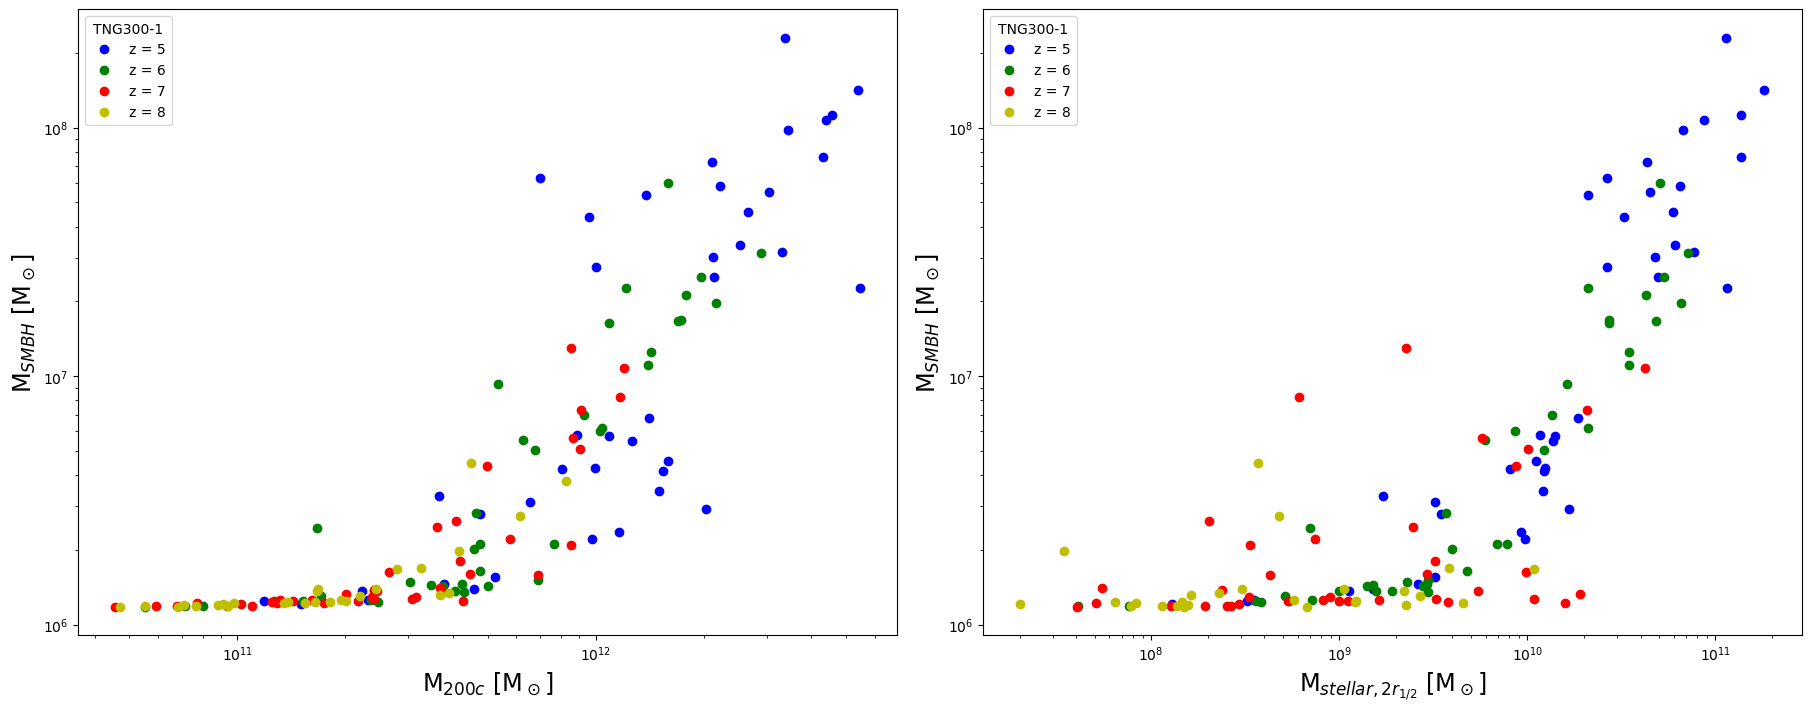

In [31]:
# Plotting the critical halo masses vs black hole masses for various snapshots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), layout='constrained')

# top = 3e8
# bottom = 1e6

colors = ['b', 'g', 'r', 'y']

for i in range(tot_snaps):
    x = np.take_along_axis(halo_mass[i], np.argsort(halo_mass[i]), axis = None)
    y = np.take_along_axis(bh_mass[i], np.argsort(halo_mass[i]), axis = None)
    ax1.plot(x, y, 'o', markersize=6, c=colors[i], label=f'z = {redshifts[i]}')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
    ax1.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
    ax1.legend(title='TNG300-1', fontsize='medium', loc='upper left')
    # ax1.set_xlim(left=4e10)
    # ax1.set_ylim(top=top, bottom=bottom)
    # ax1.grid(True)
    
    x = np.take_along_axis(stellar_mass[i], np.argsort(stellar_mass[i]), axis = None)
    y = np.take_along_axis(bh_mass[i], np.argsort(stellar_mass[i]), axis = None)
    ax2.plot(x, y, 'o', markersize=6, c=colors[i],label=f'z = {redshifts[i]}')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('M$_{stellar, 2r_{1/2}}$ [M$_\odot$]', fontsize='xx-large')
    ax2.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
    ax2.legend(title='TNG300-1', fontsize='medium', loc='upper left')
    # ax2.set_xlim(left=3e7)
    # ax2.set_ylim(top=top, bottom=bottom)
    # ax2.grid(True)
    
# i = 0
# for j in range(1):    
#     xa = np.log10(np.take_along_axis(np.array(total_halo_mass[: i+n]), np.argsort(np.array(total_halo_mass[: i+n])), axis = None))
#     ya = np.log10(np.take_along_axis(np.array(nonzero_bh[: i+n]), np.argsort(np.array(total_halo_mass[: i+n])), axis = None))
#     slope1, intercept1, _, _, _, = linregress(xa, ya)
#     if i == 0:
#         x2 = np.linspace(10.5, 15.5)
#         x_tot = 10**x2
#         y2 = slope1*x2 + intercept1
#         y_tot = 10**y2
#         plt.plot(x_tot, y_tot, 'k--',label=f'z = {redshifts[j]} ({slope1:0.3f})')
#     else:
#         x2 = np.linspace(11.5, 15.5)
#         x_tot = 10**x2
#         y2 = slope1*x2 + intercept1
#         y_tot = 10**y2
#         plt.plot(x_tot, y_tot, '--',label=f'z = {redshifts[j]} ({slope1:0.3f})')
#     # print(f'At z = {redshifts[j]}, the slope m = {slope1:0.2f}')
#     i += n
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.axvline(10**14.5, ls='--', c='brown')
# plt.xlabel('M$_{200, Crit}$ [M$_\odot$]')
# plt.ylabel('M$_{SMBH}$ [M$_\odot$]')
# plt.title('M$_{SMBH}$ vs M$_{200c}$')
# plt.legend(title='Redshifts')
# plt.tight_layout()
# plt.grid(True)
# fig.tight_layout()
# plt.savefig('cummulative_redshift_evolution_updated.png')
plt.show()

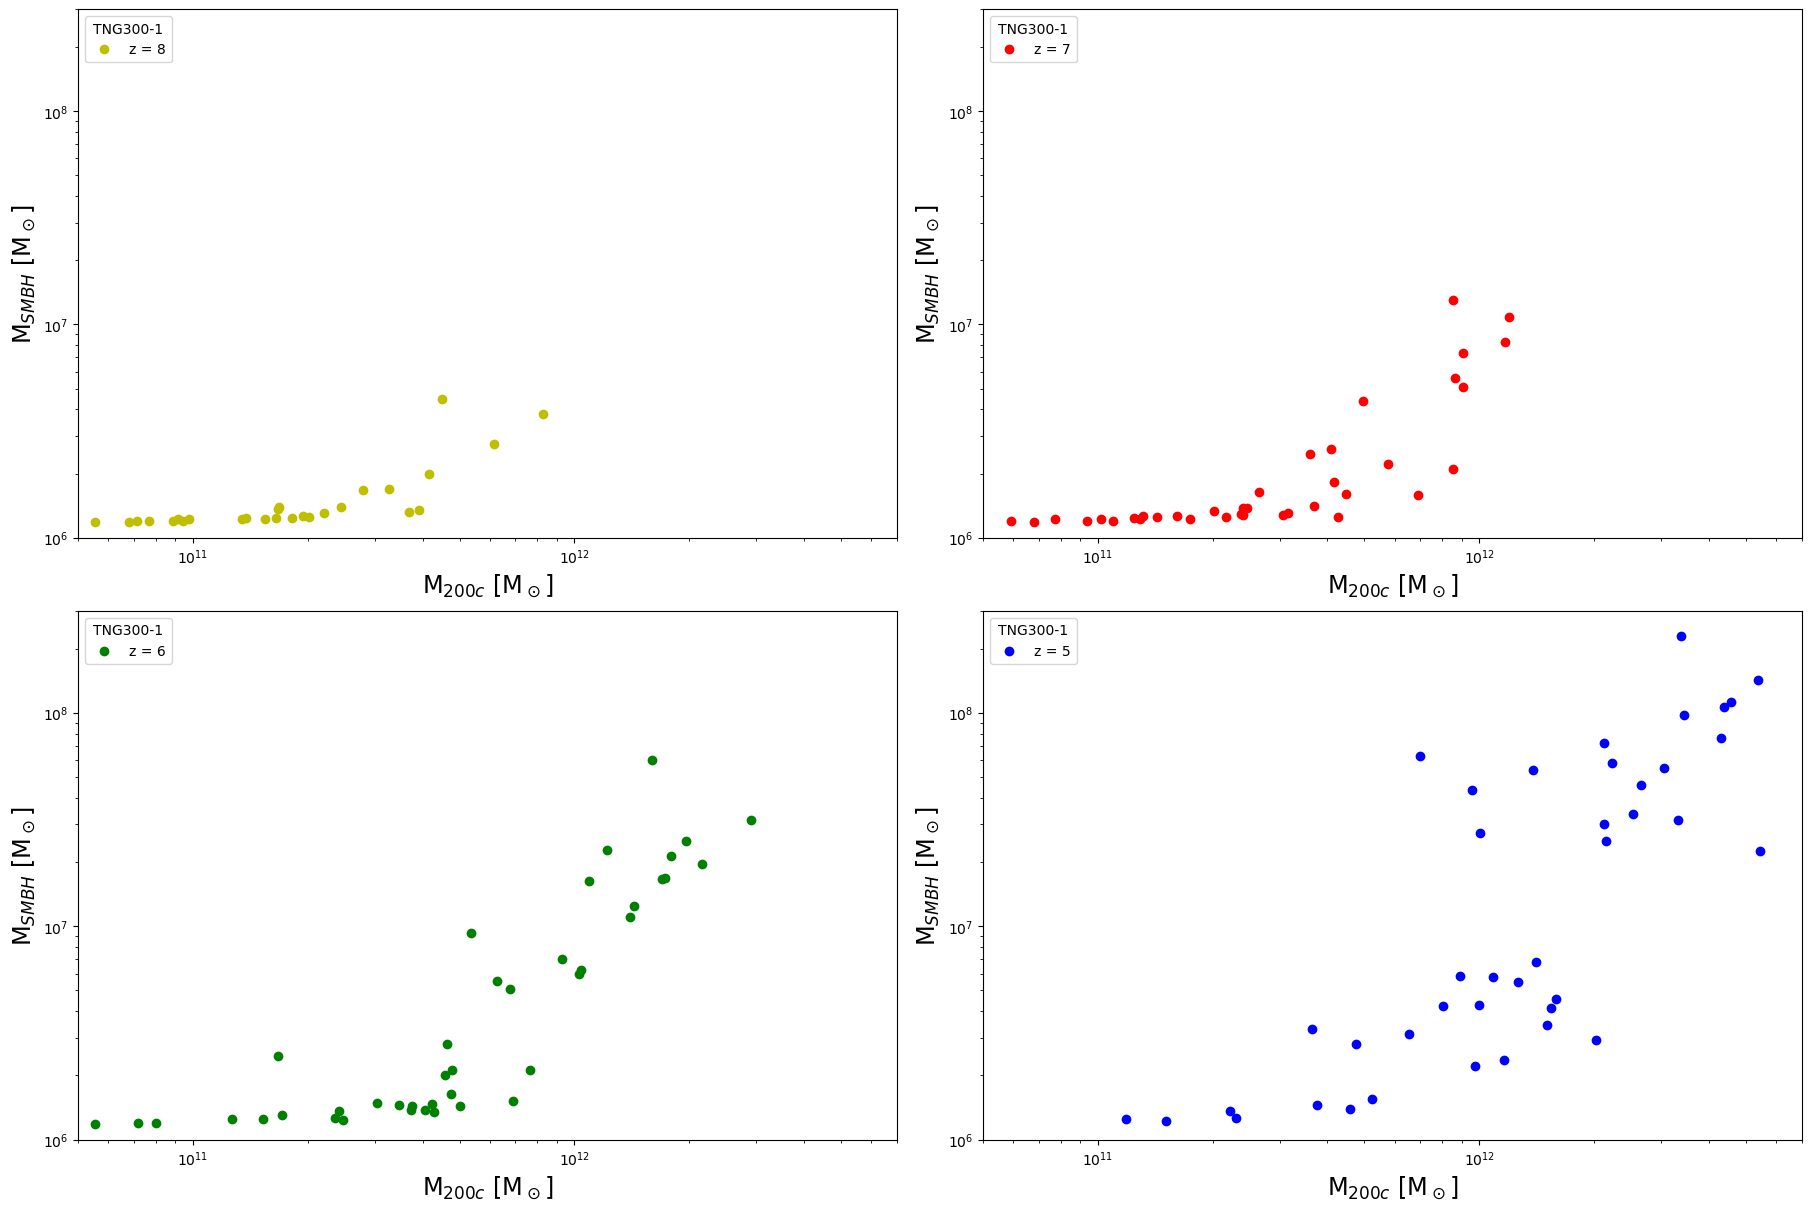

In [32]:
# Plotting the critical halo masses vs black hole masses for various snapshots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,12), layout='constrained')

# for i in range(tot_snaps):
#     x = np.take_along_axis(halo_mass[i], np.argsort(halo_mass[i]), axis = None)
#     y = np.take_along_axis(bh_mass[i], np.argsort(halo_mass[i]), axis = None)
#     ax.plot(x, y, '*', markersize=4,label=f'z = {redshifts[i]}')

left = 5e10
right = 7e12
bottom = 1e6
top = 3e8

ax4.plot(np.take_along_axis(halo_mass[0], np.argsort(halo_mass[0]), axis = None), np.take_along_axis(bh_mass[0], np.argsort(halo_mass[0]), axis = None), 'bo', label=f'z = {redshifts[0]}')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(left=left, right=right)
ax4.set_ylim(bottom=bottom, top=top)
ax4.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
ax4.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax4.legend(title='TNG300-1', loc='upper left', fontsize='medium')
    
ax3.plot(np.take_along_axis(halo_mass[1], np.argsort(halo_mass[1]), axis = None), np.take_along_axis(bh_mass[1], np.argsort(halo_mass[1]), axis = None), 'go', label=f'z = {redshifts[1]}')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(left=left, right=right)
ax3.set_ylim(bottom=bottom, top=top)
ax3.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
ax3.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax3.legend(title='TNG300-1', loc='upper left', fontsize='medium')

ax2.plot(np.take_along_axis(halo_mass[2], np.argsort(halo_mass[2]), axis = None), np.take_along_axis(bh_mass[2], np.argsort(halo_mass[2]), axis = None), 'ro', label=f'z = {redshifts[2]}')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left=left, right=right)
ax2.set_ylim(bottom=bottom, top=top)
ax2.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
ax2.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax2.legend(title='TNG300-1', loc='upper left', fontsize='medium')

ax1.plot(np.take_along_axis(halo_mass[3], np.argsort(halo_mass[3]), axis = None), np.take_along_axis(bh_mass[3], np.argsort(halo_mass[3]), axis = None), 'yo', label=f'z = {redshifts[3]}')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left=left, right=right)
ax1.set_ylim(bottom=bottom, top=top)
ax1.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
ax1.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax1.legend(title='TNG300-1', loc='upper left', fontsize='medium')
    
# plt.title('M$_{SMBH}$ vs M$_{200c}$')
# plt.tight_layout()
# plt.grid(True)
# plt.savefig('redshift_evolution_m200_updated.png')
plt.show()

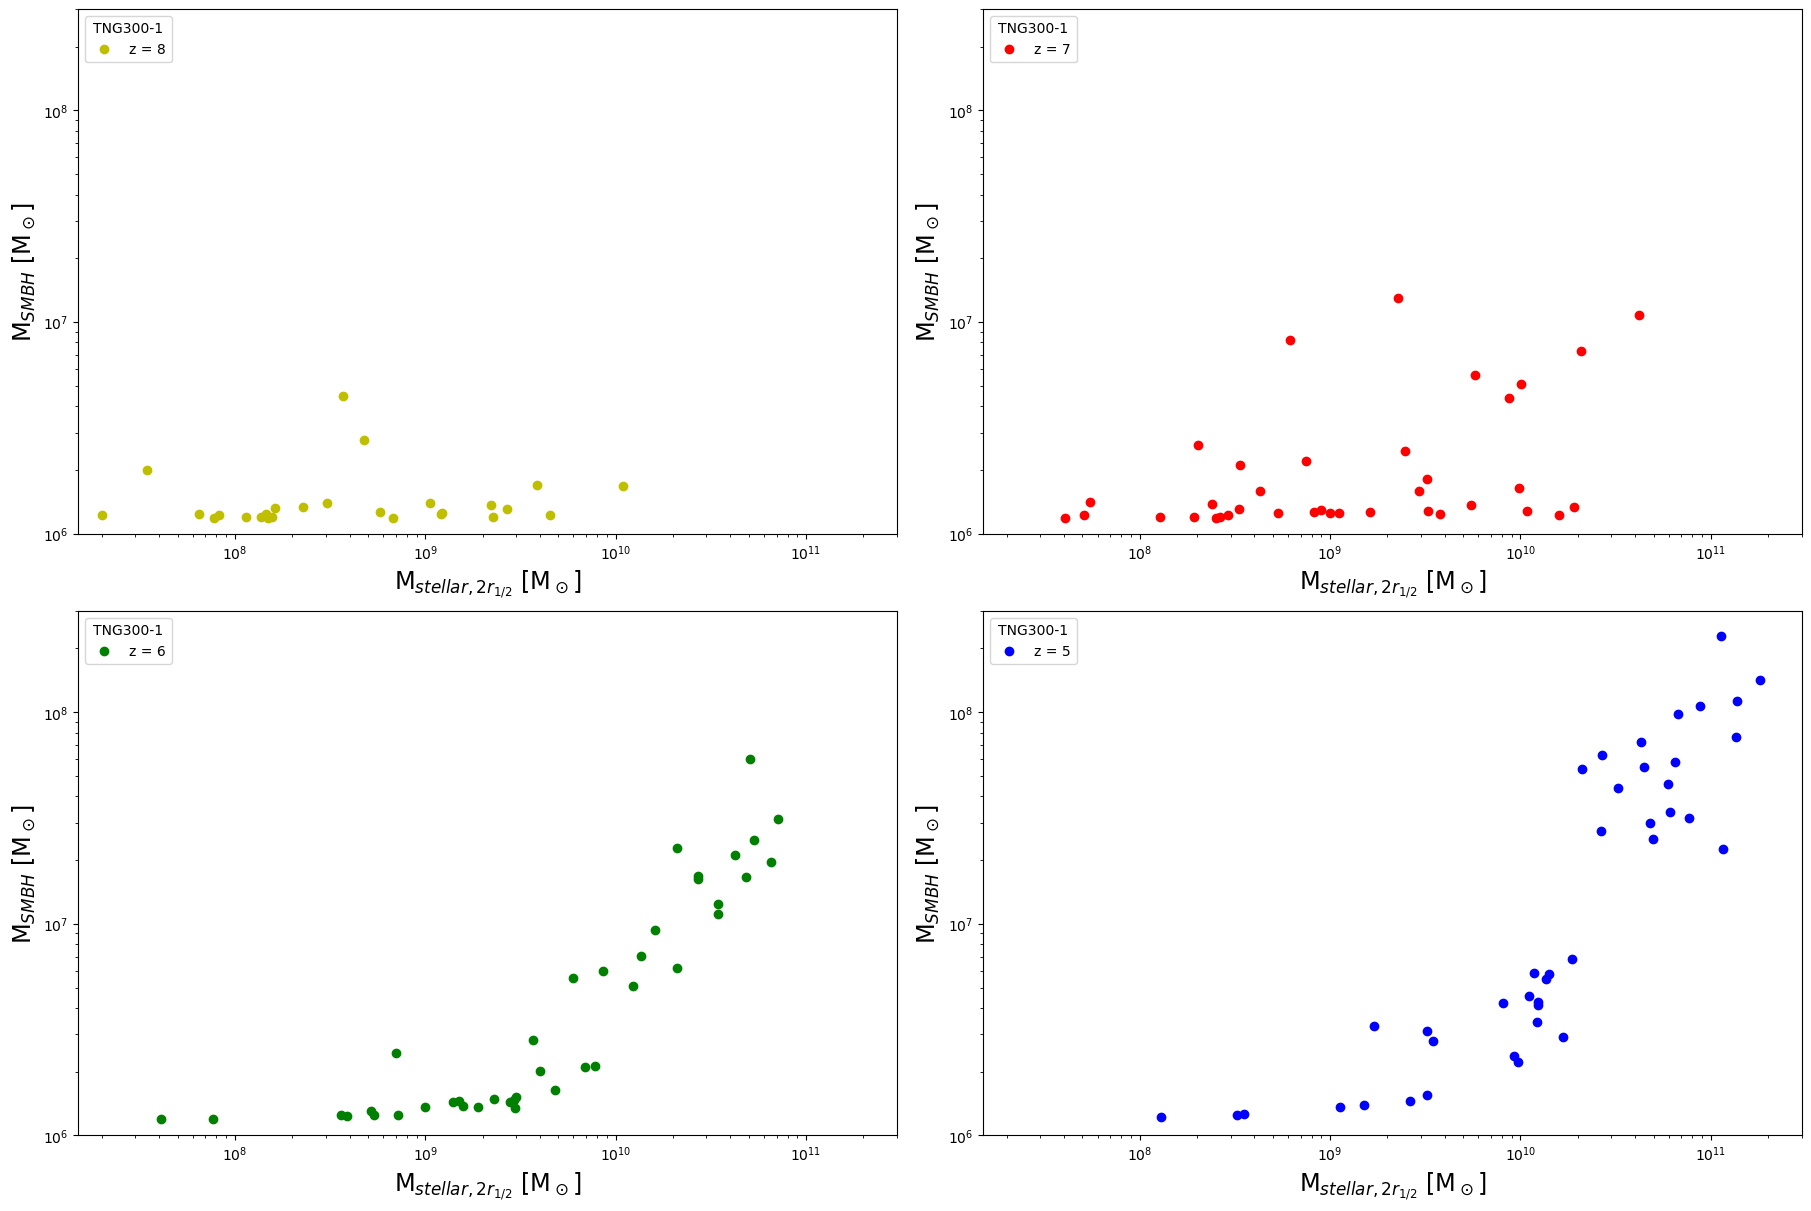

In [39]:
# Plotting the critical halo masses vs black hole masses for various snapshots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,12), layout='constrained')

# for i in range(tot_snaps):
#     x = np.take_along_axis(halo_mass[i], np.argsort(halo_mass[i]), axis = None)
#     y = np.take_along_axis(bh_mass[i], np.argsort(halo_mass[i]), axis = None)
#     ax.plot(x, y, '*', markersize=4,label=f'z = {redshifts[i]}')

left = 1.5e7
right = 3e11
bottom = 1e6
top = 3e8

ax4.plot(np.take_along_axis(stellar_mass[0], np.argsort(stellar_mass[0]), axis = None), np.take_along_axis(bh_mass[0], np.argsort(stellar_mass[0]), axis = None), 'bo', label=f'z = {redshifts[0]}')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(left=left, right=right)
ax4.set_ylim(bottom=bottom, top=top)
ax4.set_xlabel('M$_{stellar, 2r_{1/2}}$ [M$_\odot$]', fontsize='xx-large')
ax4.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax4.legend(title='TNG300-1', loc='upper left', fontsize='medium')
    
ax3.plot(np.take_along_axis(stellar_mass[1], np.argsort(stellar_mass[1]), axis = None), np.take_along_axis(bh_mass[1], np.argsort(stellar_mass[1]), axis = None), 'go', label=f'z = {redshifts[1]}')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(left=left, right=right)
ax3.set_ylim(bottom=bottom, top=top)
ax3.set_xlabel('M$_{stellar, 2r_{1/2}}$ [M$_\odot$]', fontsize='xx-large')
ax3.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax3.legend(title='TNG300-1', loc='upper left', fontsize='medium')

ax2.plot(np.take_along_axis(stellar_mass[2], np.argsort(stellar_mass[2]), axis = None), np.take_along_axis(bh_mass[2], np.argsort(stellar_mass[2]), axis = None), 'ro', label=f'z = {redshifts[2]}')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(left=left, right=right)
ax2.set_ylim(bottom=bottom, top=top)
ax2.set_xlabel('M$_{stellar, 2r_{1/2}}$ [M$_\odot$]', fontsize='xx-large')
ax2.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax2.legend(title='TNG300-1', loc='upper left', fontsize='medium')

ax1.plot(np.take_along_axis(stellar_mass[3], np.argsort(stellar_mass[3]), axis = None), np.take_along_axis(bh_mass[3], np.argsort(stellar_mass[3]), axis = None), 'yo', label=f'z = {redshifts[3]}')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(left=left, right=right)
ax1.set_ylim(bottom=bottom, top=top)
ax1.set_xlabel('M$_{stellar, 2r_{1/2}}$ [M$_\odot$]', fontsize='xx-large')
ax1.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax1.legend(title='TNG300-1', loc='upper left', fontsize='medium')
    
# plt.title('M$_{SMBH}$ vs M$_{200c}$')
# plt.tight_layout()
# plt.grid(True)
plt.savefig('redshift_evolution_mstellar_updated.png')
plt.show()

In [20]:
# # Plotting the stellar masses vs black hole masses for various snapshots
# fig, ax = plt.subplots(figsize=(10,8))
# for i in range(tot_snaps):
#     x = np.take_along_axis(halo_mass[i], np.argsort(halo_mass[i]), axis = None)
#     y = np.take_along_axis(bh_mass[i], np.argsort(halo_mass[i]), axis = None)
#     ax.plot(x, y, '*', markersize=4,label=f'z = {redshifts[i]}')
# i = 0
# for j in range(1):    
#     xa = np.log10(np.take_along_axis(np.array(total_halo_mass[: i+n]), np.argsort(np.array(total_halo_mass[: i+n])), axis = None))
#     ya = np.log10(np.take_along_axis(np.array(nonzero_bh[: i+n]), np.argsort(np.array(total_halo_mass[: i+n])), axis = None))
#     slope1, intercept1, _, _, _, = linregress(xa, ya)
#     if i == 0:
#         x2 = np.linspace(10.5, 15.5)
#         x_tot = 10**x2
#         y2 = slope1*x2 + intercept1
#         y_tot = 10**y2
#         plt.plot(x_tot, y_tot, 'k--',label=f'z = {redshifts[j]} ({slope1:0.3f})')
#     else:
#         x2 = np.linspace(11.5, 15.5)
#         x_tot = 10**x2
#         y2 = slope1*x2 + intercept1
#         y_tot = 10**y2
#         plt.plot(x_tot, y_tot, '--',label=f'z = {redshifts[j]} ({slope1:0.3f})')
#     # print(f'At z = {redshifts[j]}, the slope m = {slope1:0.2f}')
#     i += n
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.axvline(10**14.5, ls='--', c='brown')
# plt.xlabel('M$_{200, Crit}$ [log (M$_\odot$)]')
# plt.ylabel('M$_{SMBH}$ [log (M$_\odot$)]')
# plt.xlim(left=1e10)
# plt.title('M$_{SMBH}$ vs M$_{200c}$ at different redshifts (TNG300-1)')
# plt.legend(title='Redshifts')
# plt.tight_layout()
# plt.grid(True)
# plt.savefig('SMBHvsM200Crit.png')
# plt.show()

In [21]:
np.shape(total_mass)

(9, 41, 6)

In [22]:
for i in range(tot_snaps):
    for j in range(n):
        stellar_mass[i].append(total_mass[i][j][4])
    stellar_mass[i] = np.array(stellar_mass[i])
    total_stellar_mass.extend(stellar_mass[i])

In [23]:
nonzero_stellar = np.where(np.array(total_stellar_mass) == 0.0, 1 + np.array(total_stellar_mass), np.array(total_stellar_mass))

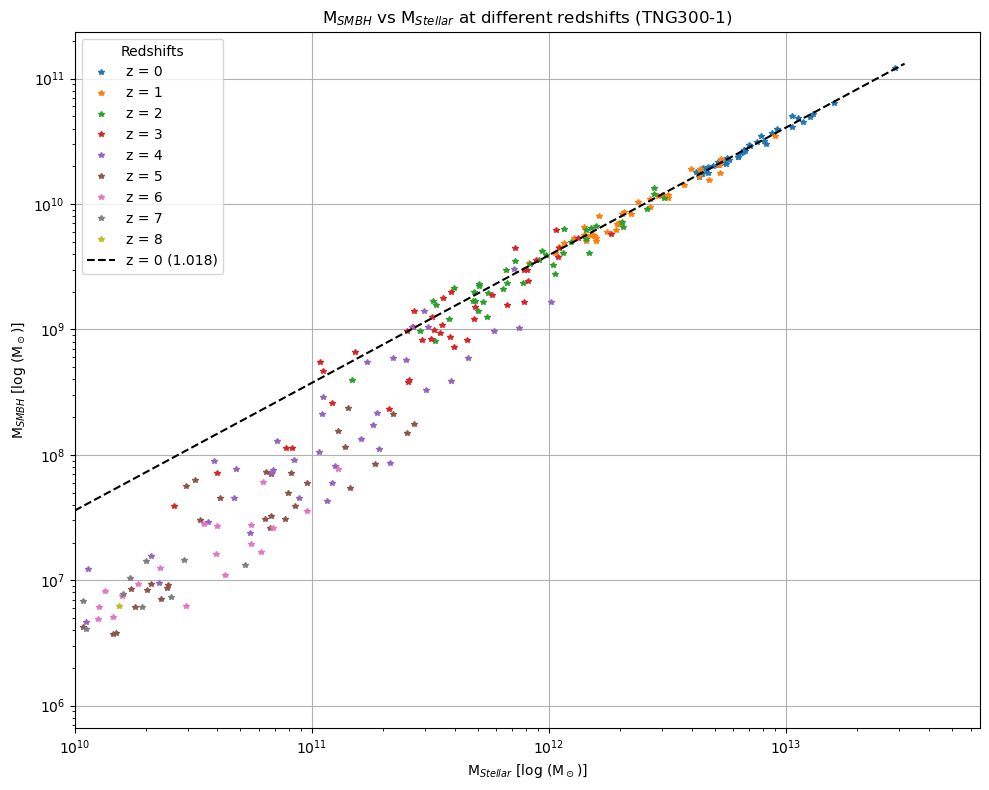

In [24]:
# Plotting the critical halo masses vs black hole masses for various snapshots
fig, ax = plt.subplots(figsize=(10,8))
for i in range(tot_snaps):
    x = np.take_along_axis(stellar_mass[i], np.argsort(stellar_mass[i]), axis = None)
    y = np.take_along_axis(bh_mass[i], np.argsort(stellar_mass[i]), axis = None)
    ax.plot(x, y, '*', markersize=4,label=f'z = {redshifts[i]}')
i = 0
for j in range(1):    
    xa = np.log10(np.take_along_axis(np.array(nonzero_stellar[: i+n]), np.argsort(np.array(nonzero_stellar[: i+n])), axis = None))
    ya = np.log10(np.take_along_axis(np.array(nonzero_bh[: i+n]), np.argsort(np.array(nonzero_stellar[: i+n])), axis = None))
    slope1, intercept1, _, _, _, = linregress(xa, ya)
    if i == 0:
        x2 = np.linspace(10, 13.5)
        x_tot = 10**x2
        y2 = slope1*x2 + intercept1
        y_tot = 10**y2
        plt.plot(x_tot, y_tot, 'k--',label=f'z = {redshifts[j]} ({slope1:0.3f})')
    else:
        x2 = np.linspace(10.5, 13.5)
        x_tot = 10**x2
        y2 = slope1*x2 + intercept1
        y_tot = 10**y2
        plt.plot(x_tot, y_tot, '--',label=f'z = {redshifts[j]} ({slope1:0.3f})')
    # print(f'At z = {redshifts[j]}, the slope m = {slope1:0.2f}')
    i += n
ax.set_xscale('log')
ax.set_yscale('log')
# plt.axvline(10**14.5, ls='--', c='brown')
plt.xlabel('M$_{Stellar}$ [log (M$_\odot$)]')
plt.ylabel('M$_{SMBH}$ [log (M$_\odot$)]')
plt.xlim(left=1e10)
plt.title('M$_{SMBH}$ vs M$_{Stellar}$ at different redshifts (TNG300-1)')
plt.legend(title='Redshifts')
plt.tight_layout()
plt.grid(True)
# plt.savefig('SMBHvsMStellarm.png')
plt.show()

In [25]:
# total_stellar_mass = []
# partType = 4

# for i in range(n):
#     stellar_info = sn.loadSubhalo(basePath, SnapNum, sub_halos_ID[i], partType, fields=fields)
#     coord = UnitConversion(stellar_info['Coordinates'] - sub_halo_pos[i], 'length')

#     # Applying periodic boundary conditions
#     np.where(coord[:, 0] > box_size/2, coord[:, 0] - box_size/2, coord[:, 0])
#     np.where(coord[:, 1] > box_size/2, coord[:, 1] - box_size/2, coord[:, 1])
#     np.where(coord[:, 2] > box_size/2, coord[:, 2] - box_size/2, coord[:, 2])

#     dist = np.array(pow(coord[:, 0], 2) + pow(coord[:, 1], 2) + pow(coord[:, 2], 2))

#     req_sh = np.nonzero(dist <= critical_dist)
#     mass = np.sum(UnitConversion(stellar_info['Masses'][req_sh[0]], 'mass'))

#     total_stellar_mass.append(mass)

Comments:$\newline$
-> As the redshift (time) varies, the mass range of both the halos and the supermassive black holes keep increasing (with time).$\newline$
-> At a particular redshift, M$_{200c}$ varies almost linearly with M$_{SMBH}$, except in the case of z = 6 (reason unknown).$\newline$
-> The slopes of the plot appears to be the same at differentredshifts, again with the exeption of z = 6. 